## Plotting hybrid model results

In [1]:
import xarray
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import scipy
import dask
import warnings
import os
import cv2

import pickle
import jax_cfd.ml.newSaveObject as saving
import haiku as hk
import jax_cfd.ml.diego_towers as mytowers

In [2]:
print("ola")

ola


In [3]:
# names = os.listdir("./../hybrid_model/sims_30_seconds")
names = os.listdir("./../hybrid_model/validation_runs/1")

for i in range(len(names)):    
    if str(names[i]) == '.ipynb_checkpoints':
        drop_ind = i
names.pop(drop_ind)
names

['README.txt',
 'dns_256x64.nc',
 'dns_2048x512.nc',
 'validation1.ipynb',
 'dns_1024x256.nc',
 'LI_256x64.nc']

In [4]:
names = sorted(names)
names

['LI_256x64.nc',
 'README.txt',
 'dns_1024x256.nc',
 'dns_2048x512.nc',
 'dns_256x64.nc',
 'validation1.ipynb']

In [5]:
names = [   
#  'README.txt',
    'dns_2048x512.nc',
    'dns_1024x256.nc',
    'LI_256x64.nc', 
    'dns_256x64.nc',
#  'validation3.ipynb'
]

In [6]:
names = [
#      'LI_256x64.nc',
#      'LI_64x16.nc',
     
     'dns_2048x512.nc',
     'dns_1024x256.nc',
#      'LI_super_256x64.nc',
#      'LI_diffuse_256x64.nc',
     'last_model_super_256x64.nc',
     'dns_256x64.nc',
#      'dns_64x16.nc',
#      'dns_diego.nc'
]

names = [
 'dns_2048x512.nc',
 'dns_1024x256.nc',
 'vel_super_direct_256x64_f8.nc',
 'dns_256x64.nc',
    
]

In [6]:
#define which datasets to import
# pairs of same inner and outer steps changing the grid from fine to coarse

# models = [
#     {
#         "name" : "1080x256_150_seconds_inner_1",
#         "kill_factor" : 1,
#         "legend" : "1080x256",
#         "plot_style" : "--c"
#     }
    
# ]

# models = []


# models = [
#     {
#         "name" : 'dns_2048x512.nc',
#         "kill_factor" : 1,
#         "legend" : "DNS: 2048x512",
#         "plot_style" : "--c"
#     },
#     {
#         "name" : 'dns_1024x256.nc',
#         "kill_factor" : 1,
#         "legend" : "DNS: 1024x256",
#         "plot_style" : "--c"
#     },
    
#     {
#         "name" : 'VEL_SUPER_RES_BEST.nc',
#         "kill_factor" : 1,
#         "legend" : "LI residuals (LARGE): 256x64",
#         "plot_style" : "--c"
#     },
#     {
#         "name" : 'vel_super_direct_256x64_f4.nc',
#         "kill_factor" : 1,
#         "legend" : "LI (f4): 256x64",
#         "plot_style" : "--c"
#     },
#     {
#         "name" : 'vel_super_direct_256x64_f8.nc',
#         "kill_factor" : 1,
#         "legend" : "LI (f8): 256x64",
#         "plot_style" : "--c"
#     },
# #     {
# #         "name" : 'vel_super_residuals_256x64_f4.nc',
# #         "kill_factor" : 1,
# #         "legend" : "LI (residuals) (f8): 256x64",
# #         "plot_style" : "--c"
# #     },
#     {
#         "name" : 'LI_diffuse_256x64.nc',
#         "kill_factor" : 1,
#         "legend" : "LI (Type 2): 256x64",
#         "plot_style" : "--c"
#     },
#     {
#         "name" : 'dns_256x64.nc',
#         "kill_factor" : 1,
#         "legend" : "DNS: 256x64",
#         "plot_style" : "--c"
#     },
# ]
    
models = [
    {
        "name" : 'dns_2048x512.nc',
        "kill_factor" : 1,
        "legend" : "DNS: 2048x512",
        "plot_style" : "--c"
    },
    {
        "name" : 'dns_1024x256.nc',
        "kill_factor" : 1,
        "legend" : "DNS: 1024x256",
        "plot_style" : "--c"
    },
    
    {
        "name" : 'LI_256x64.nc',
        "kill_factor" : 1,
        "legend" : "LI: 256x64",
        "plot_style" : "--c"
    },

    {
        "name" : 'dns_256x64.nc',
        "kill_factor" : 1,
        "legend" : "DNS: 256x64",
        "plot_style" : "--c"
    },
]
    
    
# ]

rows = len(models)
columns = 4

In [7]:
## calculate and plot vorticity
def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

In [8]:
def plot_var(models,rows,columns,var,figsize=(15,12)):
    fig, axs = plt.subplots(rows,columns, figsize=figsize, facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.1)


    axs = axs.ravel()
    
    axis = 0
    for model in models:
        model_name = model['name']
        kill_factor = model['kill_factor']
        label = model['legend']
        ds = xarray.open_dataset(f"./../hybrid_model/validation_runs/3/"+ model_name, chunks={'time': '100MB'})
#         ds = xarray.open_dataset(f'./../hybrid_model/sims_50_seconds/'+ model_name +'.nc', chunks={'time': '100MB'})
#         ds = ds.isel(sample = 0)
        outer_steps = len(ds.time)
        
        total_sim_time = max(ds.time.values)*kill_factor
        seconds_warm_up = 5
        warm_up = int(seconds_warm_up * (outer_steps/total_sim_time)) #this allows us to start plotting after a set number of seconds
        
#         warm_up = int(outer_steps*kill_factor//(columns-1))-1 #0
        
        
#         print((outer_steps*kill_factor-warm_up))
#         print(int((outer_steps*kill_factor-warm_up)//(columns-1)-1))
        if var == 'vorticity':
            vort = ds.pipe(vorticity)
        
#         for time_slice in range(warm_up,int(np.floor(outer_steps*kill_factor)),int((outer_steps*kill_factor-warm_up)//(columns-1)-1)):
        for time_slice in range(6,10):
            if var == 'u':
                field_var = ds.u[time_slice]
            elif var == 'v':
                field_var = ds.v[time_slice]
            elif var == 'vorticity':
                field_var = vort[time_slice]
            
            im = xarray.plot.pcolormesh(field_var, 'x', 'y',add_colorbar = False,cmap=seaborn.cm.rocket,ax = axs[axis],robust=True);
            axs[axis].title.set_text('time: ' + "{:.1f}".format(ds.time[time_slice]))
#             axs[axis].axis('off')
            
    
            ## Plots colorbar at the last subplot for each model
#             if (axis+1) % columns == 0:
#                 cbar = fig.colorbar(im, ax=axs[axis], shrink=1)
            

            #remove vorticity from y axis of each subplot
            axis += 1
    
#         print(max(field_var.values.flatten()))
    for i in range(len(models)):
        label = models[i]['legend']
        axs[i*columns].set_ylabel(label, rotation=90, size='large')
        
    
    fig.tight_layout()
    
    ## Plots general colorbar 
#     cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.8)
#     cbar.set_label(var, rotation=0, size='large')
    
        
    
    plt.show()
    


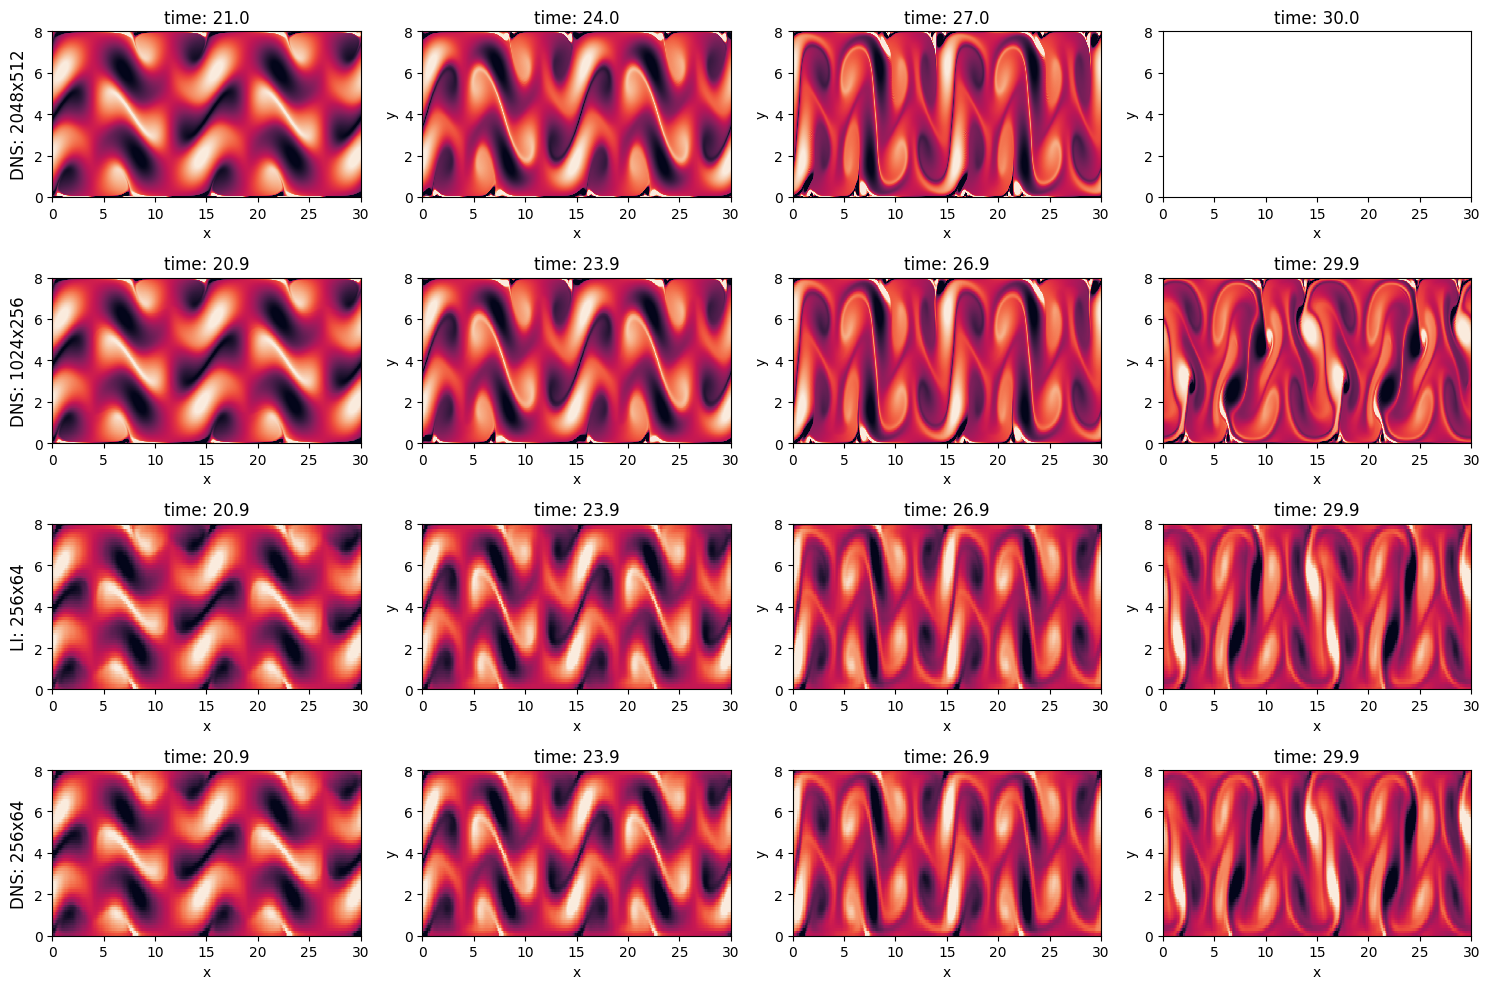

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_var(models,rows,columns,'vorticity',figsize=(15,10))

In [10]:



def xarrayToList(model_name):
    ds = xarray.open_dataset(f"./../hybrid_model/sims_30_seconds/"+ model_name, chunks={'time': '100MB'})
    u = ds.u.values
    v = ds.v.values

    data = []
    for i in range(len(ds.time.values)):
    
        data.append(np.dstack([
            u[i][:][:],
            v[i][:][:]
        ]))


    return data

ground_truth = xarrayToList("dns_2048x512.nc")
sim_1024 = xarrayToList("dns_1024x256.nc")
sim_256 = xarrayToList("dns_256x64.nc")


LI = xarrayToList('VEL_SUPER_RES_BEST.nc')

In [11]:
# Create bicubic sample
def downSampling(data,factor):
    out = []
    for thisData in data:
        out.append(thisData[::factor,::factor,:])
    return out

def upSampling(data,factor):
    times,rows,cols,channels = np.shape(data)
    out = []
    for thisData in data:
        out.append(np.dstack([
            cv2.resize(thisData[:,:,0], dsize=(int(cols*factor), int(rows*factor)), interpolation=cv2.INTER_CUBIC),
            cv2.resize(thisData[:,:,1], dsize=(int(cols*factor), int(rows*factor)), interpolation=cv2.INTER_CUBIC)
        ]))
    return out

def createBicubicInterp(data,factor):
    return upSampling(downSampling(data,factor),factor)

def createSuperresInterp(data,factor,loaded):
    bicubic = createBicubicInterp(data,factor)
    
    # now superresolve
    out = []
    for thisTime in data:
        out.append(loaded.forward_pass.apply(loaded.params,thisTime) + thisTime)
    return out




def ConvNet(x):
    cnn = mytowers.CNN(CNN_specs)
    return cnn(x)

save_path = "./models/finalER_models/LARGE_SUPER_RESIDUALS.pickle"

with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    CNN_specs = loaded.CNN_specs
    loaded.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

    
    
    
sim_to_fit = sim_1024
superres_data = createSuperresInterp(sim_to_fit,4,loaded)
bicubic_data = createBicubicInterp(sim_to_fit,4)
print("superres_data:\t" + str(np.shape(superres_data)) + "\n" + "bicubic_data:\t" + str(np.shape(bicubic_data)))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


superres_data:	(10, 1024, 256, 2)
bicubic_data:	(10, 1024, 256, 2)


In [12]:
# np.gradient(data) # = [dy,dx]

def newVorticity(data):
#     dvdx -dudy
# axis = 0 -> y derivative
    out = []
    for thisTime in data:
        dvdx = np.gradient(thisTime[:,:,1],axis=1)
        dudy = np.gradient(thisTime[:,:,0],axis=0)
        out.append(dvdx-dudy)
    return out



In [13]:
ds = xarray.open_dataset(f"./../hybrid_model/sims_30_seconds/"+ "dns_1024x256.nc", chunks={'time': '100MB'})
times = ds.time.values

[]

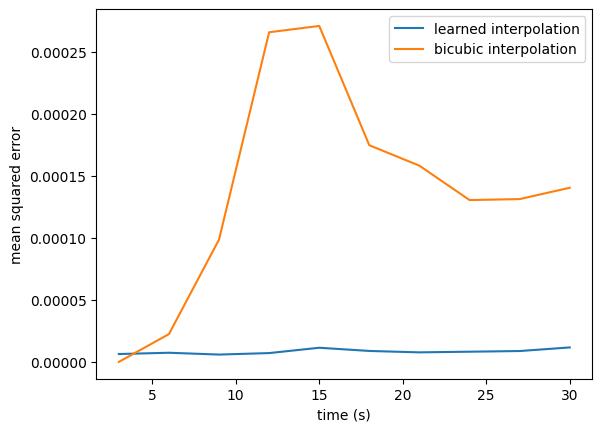

In [14]:
mse_superres = np.zeros(len(superres_data))
mse_bicubic = np.zeros(len(superres_data))
for i in range(len(superres_data)):
    mse_superres[i] = np.mean((superres_data[i]-sim_1024[i])**2)
    mse_bicubic[i] = np.mean((bicubic_data[i]-sim_1024[i])**2)

    
plt.plot(times,mse_superres,label="learned interpolation")
plt.plot(times,mse_bicubic,label="bicubic interpolation")

plt.xlabel("time (s)")
plt.ylabel("mean squared error")
plt.legend()
plt.plot()

(256,)


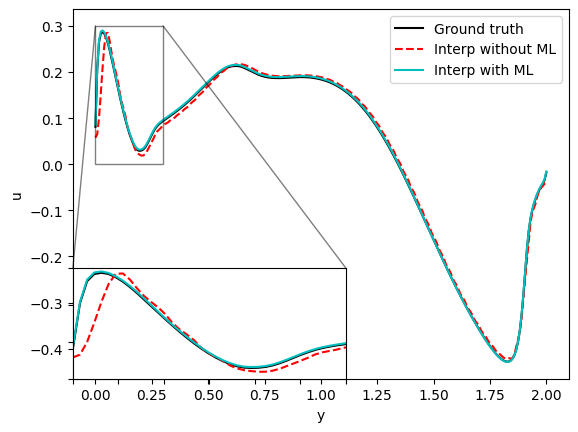

In [15]:


time_ind = 4
row = 500
vel = 0


x = np.linspace(0,2,256)
print(np.shape(x))


fig,ax = plt.subplots()
ax.plot(x,sim_1024[time_ind][row,:,vel], "k-",markersize= 2,    label="Ground truth")
ax.plot(x,bicubic_data[time_ind][row,:,vel],"r--",label="Interp without ML")
ax.plot(x,superres_data[time_ind][row,:,vel],"c", label="Interp with ML")
ax.legend()
plt.xlabel("y")
plt.ylabel("u")

# inset axes....
axins = ax.inset_axes([0.0, 0, 0.55, 0.3])
axins.plot(x,sim_1024[time_ind][row,:,vel], "k-",markersize= 4,    label="1024")
axins.plot(x,bicubic_data[time_ind][row,:,vel],"r--",label="bi-cubic only")
axins.plot(x,superres_data[time_ind][row,:,vel],"c", label="bi-cubic + super-res")
# subregion of the original image
# plt.ylim([0,0.3])
# plt.xlim([0,50])
x1, x2, y1, y2 = 0, 0.3, 0, 0.3
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

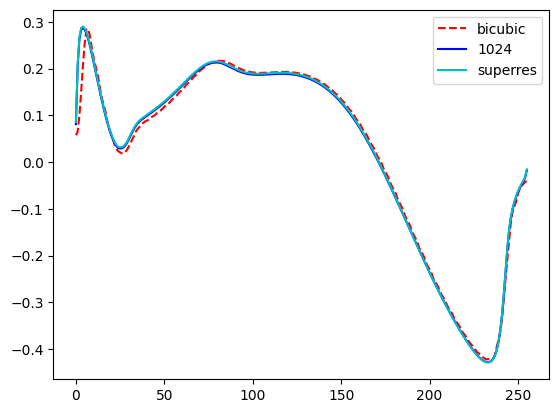

In [16]:
time_ind = 4
row = 500
vel = 0

plt.plot(bicubic_data[time_ind][row,:,vel],"r--",label="bicubic")
plt.plot(sim_1024[time_ind][row,:,vel],"b",label="1024")
plt.plot(superres_data[time_ind][row,:,vel],"c",label="superres")
# plt.plot(sampling(ground_truth,2)[time_ind][row,:,vel],"g",label="ground_truth")
plt.legend()
# plt.ylim([0,0.3])
# plt.xlim([0,50])



# fig = plt.figure(figsize = (13,8))
# ax = plt.subplot(111) #whole path

# ax.plot(bicubic_data[time_ind][row,:,vel],"r--",label="bicubic")
ax.plot(sim_1024[time_ind][row,:,vel],"b",label="1024")
ax.plot(superres_data[time_ind][row,:,vel],"c",label="superres")

# ax.set_xlim(0,5000)
# ax.set_ylim(-130,55)

# axins = zoomed_inset_axes(ax,2,loc='lower right', 
#                           axes_kwargs={"facecolor" : "lightgray"})

# axins.plot(random_walk)

# x1,x2,y1,y2 = 1000,2000, -60,-15
# axins.set_xlim(x1,x2)
# axins.set_ylim(y1,y2)

# pp,p1,p2 = mark_inset(ax,axins,loc1=1,loc2=3)
# pp.set_fill(True)
# pp.set_facecolor("lightgray")
# pp.set_edgecolor("k")
# plt.show()


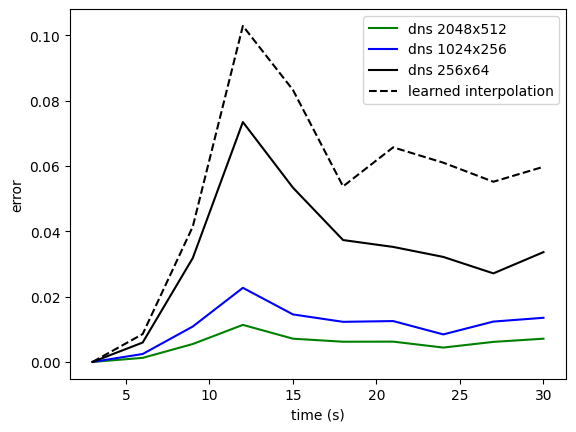

In [17]:
data = sim_1024

def calcWallErrors(data):
    errs = []
    for thisTime in data:

        walls = thisTime[:,0,:].flatten()
        np.array([walls,thisTime[:,-1,:].flatten()])

        errs.append(np.mean(abs(walls)))
    return errs

plt.plot(times,calcWallErrors(ground_truth),"g",label="dns 2048x512")
plt.plot(times,calcWallErrors(sim_1024),"b",label="dns 1024x256")
plt.plot(times,calcWallErrors(sim_256),"k",label="dns 256x64")
plt.plot(times,calcWallErrors(LI),"k--",label="learned interpolation")
plt.xlabel("time (s)")
plt.ylabel("error")
plt.legend()

In [33]:
def reynoldsNumber(max_vel,nu,L):
    return L*max_vel/nu

def findVals(data,funct=np.max):
    out = []
    for frame in data:
        out.append(funct(frame))
    return out

max_vels = findVals(ground_truth)
Re_all = []
for v_max in max_vels:
    Re_all.append(reynoldsNumber(v_max,1e-4,2))
np.max(Re_all)


11906.603574752808